## 🔰 Day 5 - Assignment (2024.11.29)
1️⃣ 삼각형, 사각형, 원 데이터를 CNN으로 학습하기  
2️⃣ Early Stopping 적용하기  
3️⃣ Loss, Accuracy 확인하기  
4️⃣ train, test의 accuracy, f1 score, confusion matrix 확인하기  
5️⃣ test 이미지 예측하기

---

In [76]:
# import libraries
import os
import shutil
import math
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import copy
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
# image data directory
original_dataset_dir = './data/handwriting_shape'

# class names
classes_list = os.listdir(original_dataset_dir)
classes_list

['circle', 'rectangle', 'triangle']

In [ ]:
# folder name to get splited images
base_dir = './splitted'

# make directory
os.mkdir(base_dir)

# make folder (image for train)
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

# make folder (image for validation)
val_dir = os.path.join(base_dir, 'val')
os.mkdir(val_dir)

# make folder (image for test)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [ ]:
# make folder
for cls in classes_list :
    os.mkdir(os.path.join(train_dir, cls))
    os.mkdir(os.path.join(val_dir, cls))
    os.mkdir(os.path.join(test_dir, cls))

for cls in classes_list :
    # get file list
    path = os.path.join(original_dataset_dir, cls)
    fnames = os.listdir(path)

    # train : val : test = 6 : 2 : 2
    train_size = math.floor(len(fnames) * 0.6)
    validation_size = math.floor(len(fnames) * 0.2)
    test_size = math.floor(len(fnames) * 0.2)

    # copy train images
    train_fnames = fnames[:train_size]
    for fname in train_fnames :
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)
        shutil.copyfile(src, dst)

    # copy val images
    validation_fnames = fnames[train_size:(validation_size + train_size)]
    for fname in validation_fnames :
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(val_dir, cls), fname)
        shutil.copyfile(src, dst)

    # copy test images
    test_fnames = fnames[(train_size + validation_size):]
    for fname in test_fnames :
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        shutil.copyfile(src, dst)

    
    print(f'[{cls}]')
    print(f'Images for Train : {len(train_fnames)}')
    print(f'Images for Validation : {len(validation_fnames)}')
    print(f'Images for Test : {len(test_fnames)}')
    print('----------------------------------')

In [78]:
# move model to GPU if available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

# batch size, epoch
BATCH_SIZE = 256
EPOCH = 30

cuda


In [79]:
# image to tensor (64 * 64)
transform_base = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

train_dataset = ImageFolder(root='./splitted/train/', transform=transform_base)
val_dataset = ImageFolder(root='./splitted/val/', transform=transform_base)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [80]:
# model
class Net(nn.Module) :

    def __init__(self) :
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=4096, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=33)

    def forward(self, x) :
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.dropout(x, p=0.25)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.dropout(x, p=0.25)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.dropout(x, p=.25)

        # x = x.view(-1, 4096)
        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [81]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
        elif score < self.best_score + self.delta:
            self.counter += 1
            # if self.verbose:
                # print(f"Loss did not improved during epoch {self.counter}")
            if self.counter >= self.patience:
                # print(f"\n====== Early stopping at epoch {self.counter}")
                return True
        else:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0
        
        return False


In [82]:
# create model
model_base = Net().to(DEVICE)

# gradient descent
optimizer = optim.Adam(model_base.parameters(), lr=0.001)

In [83]:
# training function
def train(model, train_loader, optimizer) :
    model.train()
    
    for i, (data, target) in enumerate(train_loader) :
        # print(f'Train #{i+1}/{len(data)}')
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [84]:
# evaluation function
def evaluate(model, test_loader) :
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []

    # not working gradient descent
    with torch.no_grad() :
        for i, (data, target) in enumerate(test_loader) :
            # print(f'Evaluation #{i+1}/{len(data)}')
            data = data.to(DEVICE)
            target = target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.0 * correct / len(test_loader.dataset)
    f1 = f1_score(all_targets, all_preds, average='weighted')
    cm = confusion_matrix(all_targets, all_preds)

    return test_loss, test_accuracy, f1, cm

In [87]:
# train_baseline func
def train_baseline(model, train_loader, val_loader, optimizer, num_epochs=30, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_acc = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(1, num_epochs + 1):
        train(model, train_loader, optimizer)
        train_loss, train_acc, _, _ = evaluate(model, train_loader)
        val_loss, val_acc, val_f1, val_cm = evaluate(model, val_loader)

        if val_acc > best_acc :
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Train #{epoch}')
        print(f'[Train] Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}%')
        print(f'[Validation] Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}%')
        print('[Confusion Matrix]')
        print(val_cm)
        print('--------------------------------------------------------')

        if early_stopping(val_loss, model):
            print(f"\n====== Early stopped at {epoch+1} epoch ======\n")
            break

    # after training, best weight model
    model.load_state_dict(best_model_wts)
    return model

In [88]:
# train
# base = train_baseline(model_base, train_loader, val_loader, optimizer, EPOCH)
base = train_baseline(model_base, train_loader, val_loader, optimizer, num_epochs=100, patience=5)
torch.save(base, 'baseline_with_early_stopping.pt')

Train #1
[Train] Loss: 1.3237 | Accuracy: 55.5556%
[Validation] Loss: 1.5526 | Accuracy: 0.0000%
[Confusion Matrix]
[[0 1 0]
 [1 0 0]
 [0 1 0]]
--------------------------------------------------------
Train #2
[Train] Loss: 1.4216 | Accuracy: 44.4444%
[Validation] Loss: 1.2933 | Accuracy: 33.3333%
[Confusion Matrix]
[[1 0 0]
 [0 0 1]
 [1 0 0]]
--------------------------------------------------------
Train #3
[Train] Loss: 1.5191 | Accuracy: 33.3333%
[Validation] Loss: 3.1512 | Accuracy: 33.3333%
[Confusion Matrix]
[[0 0 1]
 [1 0 0]
 [0 0 1]]
--------------------------------------------------------
Train #4
[Train] Loss: 2.1019 | Accuracy: 11.1111%
[Validation] Loss: 1.4491 | Accuracy: 66.6667%
[Confusion Matrix]
[[1 0 0]
 [0 1 0]
 [0 1 0]]
--------------------------------------------------------
Train #5
[Train] Loss: 1.8327 | Accuracy: 22.2222%
[Validation] Loss: 1.4684 | Accuracy: 66.6667%
[Confusion Matrix]
[[1 0 0]
 [0 1 0]
 [1 0 0]]
------------------------------------------------

In [89]:
# predict
test_dataset = ImageFolder(root='./splitted/test/', transform=transform_base)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
data_iter = iter(test_loader)
batch_x, batch_y = next(data_iter)

print("- Feature (x):", batch_x)
print("- Label (y):", batch_y)
print("- Feature shape:", batch_x.shape)
print("- Label shape:", batch_y.shape)

- Feature (x): tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1.

In [90]:
# predict
test_dataset = ImageFolder(root='./splitted/test/', transform=transform_base)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

model = torch.load('baseline_with_early_stopping.pt')

with torch.no_grad() :
    result = []

    for data, target in test_loader :
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        output = model(data)
        
        pred = output.max(1, keepdim=True)[1]
        pred = pred.cpu().numpy()
        result = result + pred.reshape(-1).tolist()

print(result)

results_data = []
classes_dict = test_dataset.class_to_idx
classes_names = list(classes_dict.keys())

for r1 in result :
    n1 = classes_names[r1]
    results_data.append(n1)

print(results_data)

[1, 0, 0]
['rectangle', 'circle', 'circle']


● Test Loss: 2.0557
● Test Accuracy: 66.6667%
● Test F1 Score: 0.5556
● Confusion Matrix for Test:
[[1 0 0]
 [0 1 0]
 [1 0 0]]


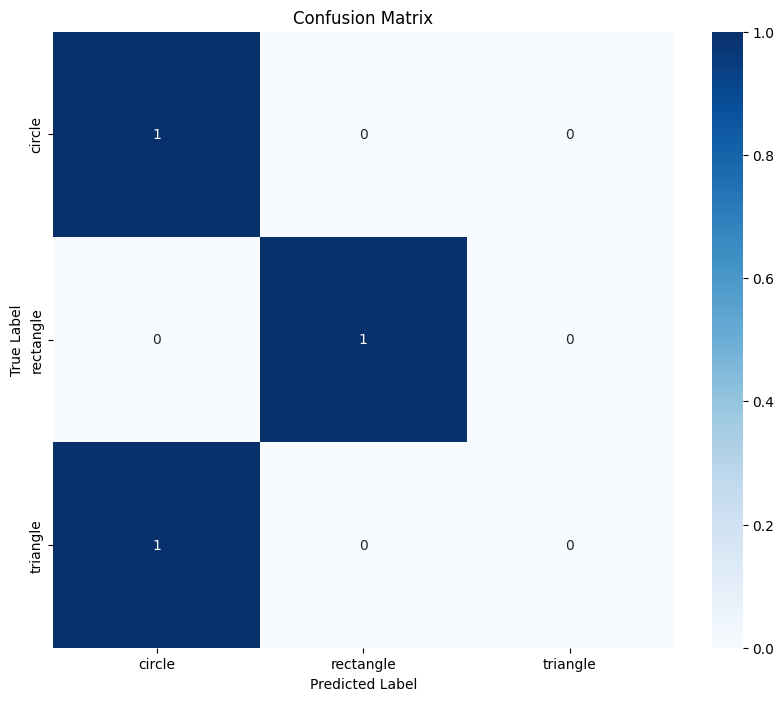

In [92]:
model = torch.load('baseline_with_early_stopping.pt')

test_dataset = ImageFolder(root='./splitted/test/', transform=transform_base)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_loss, test_acc, test_f1, test_cm = evaluate(model, test_loader)

print(f'● Test Loss: {test_loss:.4f}')
print(f'● Test Accuracy: {test_acc:.4f}%')
print(f'● Test F1 Score: {test_f1:.4f}')
print('● Confusion Matrix for Test:')
print(test_cm)

plt.figure(figsize=(10, 8))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes_names, yticklabels=classes_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

---